# Test file

## Imports

In [1]:
# MLflow
import mlflow
from mlflow.models import infer_signature

# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualizations
import matplotlib.pyplot as plt

# math functions
import numpy as np

## Load training data

In [2]:
# read CSV file
import os
import glob

# data frames
import pandas as pd

# future warnings
import warnings
warnings.filterwarnings("ignore")

df = pd.DataFrame()
df_files = {}
for fname in glob.glob(os.path.abspath('./data/**/*.csv')):
    _df=pd.read_csv(fname)
    df = df.append(_df.copy(), ignore_index=True)
    break
    df_files[os.path.basename(fname)] = _df
    
df['ai_mention'] = df['blurb'].str.contains('artificial intelligence')
df['backers_count'] = pd.to_numeric(df['backers_count'], errors='coerce')
df = df.dropna(subset=["backers_count"], how="all")
df = df.dropna(subset=["ai_mention"], how="all")

In [3]:
print(len(df.index))
df.info()
df.loc[df['ai_mention']==True]

3322
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3322 entries, 0 to 3321
Data columns (total 42 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   backers_count             3322 non-null   int64  
 1   blurb                     3322 non-null   object 
 2   category                  3322 non-null   object 
 3   converted_pledged_amount  3173 non-null   float64
 4   country                   3322 non-null   object 
 5   country_displayable_name  3322 non-null   object 
 6   created_at                3322 non-null   int64  
 7   creator                   3322 non-null   object 
 8   currency                  3322 non-null   object 
 9   currency_symbol           3322 non-null   object 
 10  currency_trailing_code    3322 non-null   bool   
 11  current_currency          3322 non-null   object 
 12  deadline                  3322 non-null   int64  
 13  disable_communication     3322 non-null   bool   
 14  fx_

,backers_count,blurb,category,converted_pledged_amount,country,country_displayable_name,created_at,creator,currency,currency_symbol,...,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_exchange_rate,usd_pledged,usd_type,video,ai_mention
1483,3,The website-builder of the future! Create your...,"{""id"":51,""name"":""Software"",""analytics_name"":""S...",1545.0,DE,Germany,1698328174,"{""id"":74185941,""name"":""Christopher Wittmann"",""...",EUR,€,...,False,failed,1704633241,1.070668,"{""web"":{""project"":""https://www.kickstarter.com...",1.095470,1510.713112,domestic,"{""id"":1258123,""status"":""successful"",""hls"":""htt...",True
2905,2,Analyze the financial statements of businesses...,"{""id"":51,""name"":""Software"",""analytics_name"":""S...",19.0,GB,the United Kingdom,1666485650,"{""id"":772337108,""name"":""Hakkı Özgür ALACA"",""sl...",GBP,£,...,False,failed,1672179074,1.161044,"{""web"":{""project"":""https://www.kickstarter.com...",1.208789,18.576700,domestic,"{""id"":1192761,""status"":""successful"",""hls"":""htt...",True


## Train the model

In [10]:
# MLflow model
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer as imp

# Enable automatic logging to MLflow
mlflow.set_experiment("MLflow")
mlflow.autolog()

# Use the Kickstarter dataset
"""
    ['backers_count', 'blurb', 'category', 'converted_pledged_amount', 'country', 'country_displayable_name', 
    'created_at', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'deadline', 
    'disable_communication', 'fx_rate', 'goal', 'id', 'is_disliked', 'is_launched', 'is_liked', 'is_starrable', 
    'launched_at', 'location', 'name', 'percent_funded', 'photo', 'pledged', 'prelaunch_activated', 'profile', 
    'slug', 'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at', 'static_usd_rate', 'urls', 
    'usd_exchange_rate', 'usd_pledged', 'usd_type', 'video']
"""
X = df[['backers_count','spotlight','staff_pick','percent_funded']]
y = df['ai_mention']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

params = {'n_estimators':100, 'max_depth':6, 'max_features':3}

# Train the model
rf = RandomForestRegressor(**params)

# MLflow triggers logging automatically upon model fitting
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

2024/02/14 17:59:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/14 17:59:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e147313494a2438a9e50dcd44ac44ee6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


## Graph the model

0.0005800577280721686


ValueError: x and y must be the same size

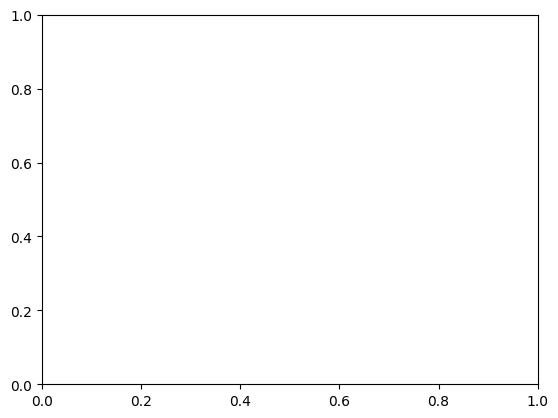

In [12]:
accuracy = mean_absolute_error(y_test, y_pred)
print(accuracy)
plt.scatter(X_train, y_train, color='red')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('AI mention')
plt.ylabel('Backers')
plt.title('Linear Regression - AI mention vs. Backers')
plt.show()

In [ ]:
# Random Forest test
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz

#area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
X = dataset[['area','bedrooms','bathrooms','stories']]
rf_X_train, rf_X_test, rf_y_train, rf_y_test = train_test_split(X, y)
rf = RandomForestRegressor(n_estimators=100, max_depth=6, max_features=3)

rf_y_pred = rf.fit(rf_X_train, rf_y_train)